In [ ]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 2.0 MB/s eta 0:00:00


In [ ]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from shapely.geometry import LineString

In [ ]:
# Specify location for road network extraction
region = "Austin, Texas, USA"

In [ ]:
# Retrieve road network and building data
road_graph = ox.graph_from_place(region, network_type="drive")
building_data = ox.features.features_from_place(region, {"building": True})

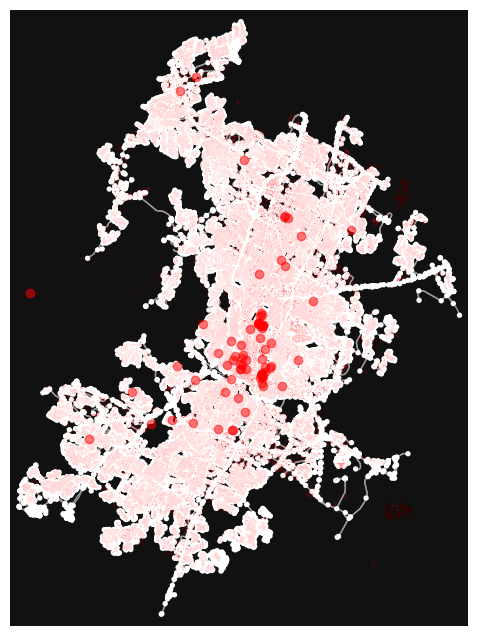

In [ ]:
# Visualizing road network with obstacles
def display_map(graph, structures):
    fig, axis = ox.plot_graph(graph, show=False, close=False)
    structures.plot(ax=axis, color="red", alpha=0.5)
    plt.show()

display_map(road_graph, building_data)

In [ ]:
# Fitness evaluation function
def evaluate_layout(layout, graph, obstacles):
    score = 0
    total_distance = 0
    for road in layout:
        x_start, y_start, x_end, y_end = road
        distance = np.sqrt((x_start - x_end)**2 + (y_start - y_end)**2)
        total_distance += distance

        # Penalize roads that intersect obstacles
        for obstruction in obstacles:
            if road_intersects(road, obstruction):
                score -= 100

    # Favor shorter road networks
    score -= total_distance
    return score

In [ ]:
# Check if a road segment crosses an obstacle
def road_intersects(segment, structure):
    road_segment = LineString([(segment[0], segment[1]), (segment[2], segment[3])])
    return road_segment.intersects(structure)

In [ ]:
# Generate random road segments
def create_random_layout(graph, segment_count=10):
    nodes = list(graph.nodes)
    layout = []
    for _ in range(segment_count):
        point1, point2 = random.sample(nodes, 2)
        x1, y1 = graph.nodes[point1]["x"], graph.nodes[point1]["y"]
        x2, y2 = graph.nodes[point2]["x"], graph.nodes[point2]["y"]
        layout.append((x1, y1, x2, y2))
    return layout

In [ ]:
# Genetic Algorithm for road optimization
def optimize_road_network(graph, obstacles, generations=5, pop_size=10):
    population = [create_random_layout(graph) for _ in range(pop_size)]

    for _ in range(generations):
        fitness_scores = [evaluate_layout(ind, graph, obstacles) for ind in population]
        best_indices = np.argsort(fitness_scores)[-pop_size//2:]
        selected_population = [population[i] for i in best_indices]

        # Crossover and mutation
        next_population = []
        while len(next_population) < pop_size:
            parent_a, parent_b = random.sample(selected_population, 2)
            split = random.randint(1, len(parent_a) - 1)
            child = parent_a[:split] + parent_b[split:]
            next_population.append(child)

        for i in range(len(next_population)):
            if random.random() < 0.1:
                mutate_index = random.randint(0, len(next_population[i]) - 1)
                new_point1, new_point2 = random.sample(list(graph.nodes), 2)
                x1, y1 = graph.nodes[new_point1]["x"], graph.nodes[new_point1]["y"]
                x2, y2 = graph.nodes[new_point2]["x"], graph.nodes[new_point2]["y"]
                next_population[i][mutate_index] = (x1, y1, x2, y2)

        population = next_population

    best_layout = max(population, key=lambda x: evaluate_layout(x, graph, obstacles))
    return best_layout


In [ ]:
# Convert building geometries to obstacles
obstacle_list = building_data.geometry.tolist()

In [ ]:
# Run optimization
optimal_network = optimize_road_network(road_graph, obstacle_list)

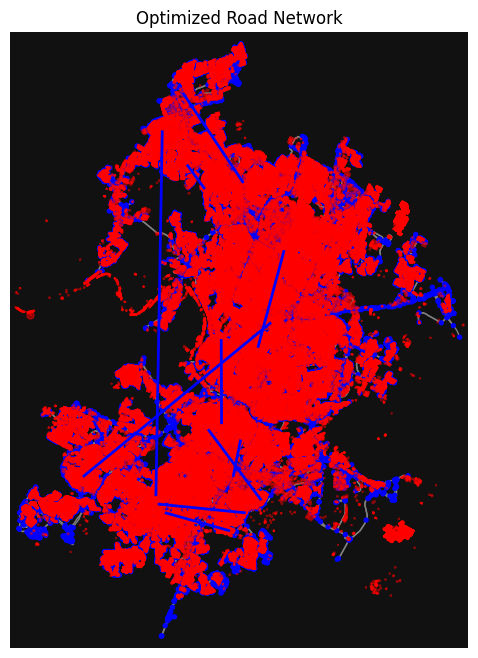

In [ ]:
# Visualization
def render_network(graph, obstacles, roads):
    fig, ax = ox.plot_graph(graph, show=False, close=False, node_color="blue", edge_color="gray")

    for obs in obstacles:
        if obs.geom_type == "Polygon":
            ax.plot(*obs.exterior.xy, color="red", alpha=0.5)
        elif obs.geom_type == "Point":
            ax.plot(obs.x, obs.y, "ro", markersize=5, alpha=0.5)

    for road in roads:
        ax.plot([road[0], road[2]], [road[1], road[3]], "b-", linewidth=2)

    plt.title("Optimized Road Network")
    plt.show()

render_network(road_graph, obstacle_list, optimal_network)

In [ ]:
region = input("Enter the city or region for road planning (e.g., 'Austin, Texas, USA'): ")
segment_count = int(input("Enter the number of road segments to generate: "))

# Retrieve road network and buildings
road_graph = ox.graph_from_place(region, network_type="drive")
building_data = ox.features.features_from_place(region, {"building": True})

# Use segment_count in road generation
optimal_network = optimize_road_network(road_graph, building_data.geometry.tolist(), generations=5, pop_size=10)

# Render optimized road layout
render_network(road_graph, building_data.geometry.tolist(), optimal_network)

Enter the city or region for road planning (e.g., 'Austin, Texas, USA'): "New York, USA"
Enter the number of road segments to generate: 5
